# General State Markov Chains and MCMC
**Author:** Ivan Vovk

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as Q
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

## **1. Metropolis-Hastings Langevin Algorithm**

If we have:
$$U(x) = \frac{x_0^2}{2p} + (x_1 + bx_0^2 - pb)^2 + \sum_{k=2}^{n}{\frac{x_k^2}{2}} =$$
$$= \frac{x_0^2}{2p} + x_1^2 + 2bx_1x_0^2 - 2bpx_1 - 2b^2px_0^2 + b^2x_0^4 + b^2p^2 + \sum_{k=2}^{n}{\frac{x_k^2}{2}}$$

then the gradient of $U(x)$:
$$\nabla U(x) = (\frac{x_0}{p} + 4bx_0x_1 - 4b^2px_0 + 4b^2x_0^3;$$
$$2x_1 + 2bx_0^2 - 2bp;$$
$$x_2;$$
$$x_3;$$
$$...)$$

In [70]:
def U(x, p=100, b=0.1):
    return x[0]**2 / (2 * p) + (x[1] + b * x[0] ** 2 - p * b)**2 + (x[2:]**2).sum() / 2

def grad_U(x, p=100, b=0.1):
    grad = np.zeros(x.shape)
    for i in range(x.shape[0]):
        if i == 0:
            grad[0] = x[0] / p + 4 * b * x[0] * x[1] - 4 * (b**2) * p * x[0] + 4 * (b**2) * (x[0] ** 3)
        elif i == 1:
            grad[1] = 2 * x[1] + 2 * b * (x[0]**2) - 2 * b * p
        else:
            grad[i] = x[i]
    return grad
    
def pi(x, p=100, b=0.1):
    return np.exp(-U(x, p, b))

def kernel(curr_state, h=0.5, d=10, p=100, b=0.1):
    mu = curr_state - h * grad_U(curr_state, p, b)
    sigma = 2 * h * np.ones(d)
    return np.random.normal(loc=mu, scale=sigma, size=d)

def acceptance_prob(curr_state, candidate, p=100, b=0.1, h=0.1):
    return min(
        1,
        pi(candidate, p, b) / pi(curr_state, p, b) \
        * Q(candidate - h * grad_U(candidate, p, b), 2 * h * np.eye(10)).pdf(candidate)) \
        / (Q(curr_state - h * grad_U(curr_state, p, b), 2 * h * np.eye(10)).pdf(curr_state) + 1e-15)

def gen_samples_mala(N=10000, d=10, h=1e-3, p=100, b=0.1, random_state=123):
    # Initial point
    np.random.seed(random_state)
    curr_state = np.random.normal(
        loc=[np.random.choice([-1, 1]) * item for item in [1, 1] + [0] * (d - 2)],
        scale=0.1, size=d)
    
    accepted_samples = []
    rejected_samples = []
    while len(accepted_samples) + len(rejected_samples) != N:  # for h search
        # Sample candidate from our kernel
        candidate = kernel(curr_state, h, d, p, b)

        # Calculate acceptance probability
        u = np.random.uniform(0, 1)
        if u <= acceptance_prob(curr_state, candidate, p, b, h=h):
            curr_state = candidate
            accepted_samples.append(candidate)
        else:
            rejected_samples.append(candidate)
    return accepted_samples, rejected_samples

### How $\pi$ looks like in 2D case

In [71]:
points = []

heatmap = np.zeros((200, 200))
for i, x1 in enumerate(np.linspace(-40, 40, 200)):
    for j, x2 in enumerate(np.linspace(-50, 30, 200)):
        heatmap[i, j] = pi(np.array([x1, x2]))

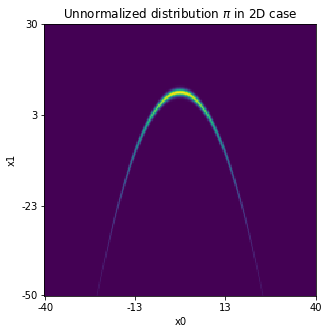

In [72]:
plt.figure(figsize=(5, 5));
plt.imshow(heatmap.T, origin='bottom');
plt.xticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-40, 40, 4, dtype=int));
plt.yticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-50, 30, 4, dtype=int));
plt.title('Unnormalized distribution $\pi$ in 2D case');
plt.xlabel('x0');
plt.ylabel('x1');

### Optimal `h` parameter search

In [73]:
ratios = []
h_grid = np.linspace(1e-7, 1, 100)

for i, h in enumerate(tqdm(h_grid)):
    accepted, rejected = gen_samples_mala(N=200, h=h, random_state=i)
    ratios.append(len(accepted) / (len(accepted) + len(rejected)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


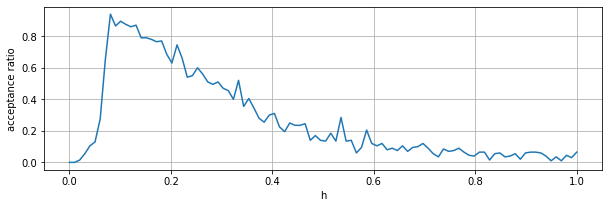

In [74]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(h_grid, ratios);
plt.xlabel('h');
plt.ylabel('acceptance ratio');

### Sampling

In [79]:
accepted, rejected = gen_samples_mala(N=10000, h=0.3, random_state=1234)

In [80]:
len(accepted), len(rejected)

(3776, 6224)

### Visualization

In [81]:
pca = PCA(n_components=2)
reducted_accepted = pca.fit_transform(accepted)

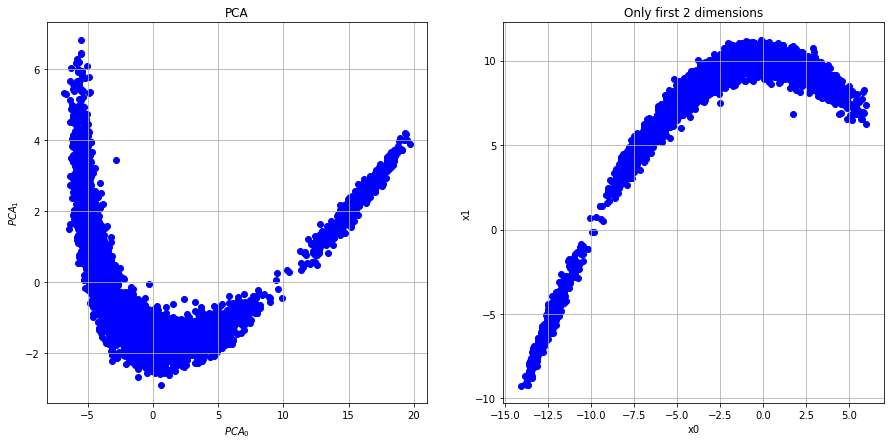

In [82]:
plt.figure(figsize=(15,7));

plt.subplot(1, 2, 1);
plt.title('PCA')
plt.grid(True);
plt.scatter(x=[point[0] for point in reducted_accepted],
            y=[point[1] for point in reducted_accepted], color='blue');
plt.xlabel('$PCA_0$');
plt.ylabel('$PCA_1$');

plt.subplot(1, 2, 2);
plt.title('Only first 2 dimensions')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted],
            y=[point[1] for point in accepted], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

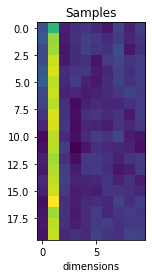

In [83]:
plt.imshow(np.array(accepted[:20]));
plt.title('Samples');
plt.xlabel('dimensions');

### Theoretical and empirical expectations of $X_2$

In [84]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_mala(N=10000, h=0.3, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  4.95s/it]


In [85]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Empirical expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Empirical expectation = 8.147602234410279


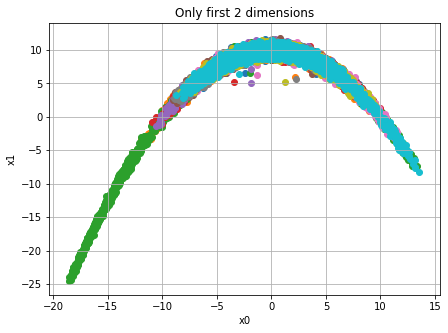

In [86]:
plt.figure(figsize=(7, 5));
plt.title('Only first 2 dimensions');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');

From the heatmap of $\pi$ it is clear that the highest probability space lies higher than 0 for the second dimension. Running MCMC pushes walk to this space (at the picture above it is illustrated that most of the points are situated at ~5-10 for the second dimension) and it is hard to explore lower probability areas for the algorithm as it coordinates his movement vector with the gradient of $U(x)$. To manage this issue one needs to initialize the first point in various ways and sample much bigger number of points than 10k. 

___
## **2. Random Walk Metropolis Algorithm**

In [15]:
def acceptance_prob_rwm(curr_state, candidate, p=100, b=0.1):
    return min(1, pi(candidate, p, b) / pi(curr_state, p, b))

def kernel_rwm(curr_state, d=10, proposal='normal', proposal_params={'loc': 0., 'scale': 0.1}):
    proposal_params.update({'size': d})
    proposal_dist = getattr(np.random, proposal)
    proposal_jump = proposal_dist(**proposal_params)
    candidate = curr_state + proposal_jump
    return candidate

def gen_samples_rwm(
    N=10000,
    d=10, p=100, b=0.1,
    proposal='normal',
    proposal_params={'loc': 0., 'scale': 0.2},
    random_state=123
):
    # Initial point
    np.random.seed(seed=random_state)
    curr_state = np.random.normal(
        loc=[np.random.choice([-1, 1]) * item for item in [1, 1] + [0] * (d - 2)],
        scale=0.1, size=d)
    
    accepted_samples = []
    rejected_samples = []
    while len(accepted_samples) + len(rejected_samples) != N:  # for h search
        # Sample candidate from our kernel
        candidate = kernel_rwm(curr_state, d, proposal=proposal, proposal_params=proposal_params)

        # Calculate acceptance probability
        u = np.random.uniform(0, 1)
        if u <= acceptance_prob_rwm(curr_state, candidate, p, b):
            curr_state = candidate
            accepted_samples.append(candidate)
        else:
            rejected_samples.append(candidate)
    return accepted_samples, rejected_samples

### Normal proposal

In [47]:
scale_grid = np.linspace(1e-7, 2, 100)

In [48]:
acceptance_ratios = []
for i, scale in enumerate(tqdm(scale_grid)):
    accepted_rwm, rejected_rwm = gen_samples_rwm(N=200, proposal_params={'loc': 0., 'scale': scale}, random_state=i)
    acceptance_ratios.append(len(accepted_rwm) / (len(accepted_rwm) + len(rejected_rwm)))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.96it/s]


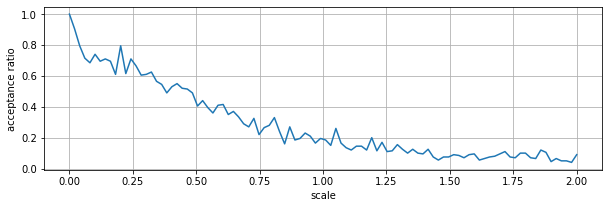

In [49]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(scale_grid, acceptance_ratios);
plt.xlabel('scale');
plt.ylabel('acceptance ratio');

In [50]:
accepted_rwm, rejected_rwm = gen_samples_rwm(N=10000, proposal_params={'loc': 0., 'scale': 0.5}, random_state=1234)
len(accepted_rwm), len(rejected_rwm)

(3977, 6023)

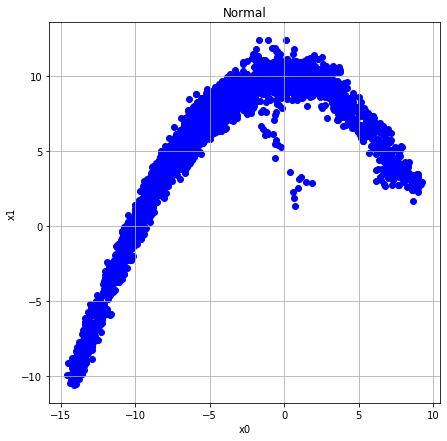

In [20]:
plt.figure(figsize=(7,7));

plt.title('Normal')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted_rwm],
            y=[point[1] for point in accepted_rwm], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

**Empirical expectation for the second dimension**

In [21]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_rwm(N=10000, proposal_params={'loc': 0., 'scale': 0.5}, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]


In [22]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Empirical expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Empirical expectation = 4.574796519152357


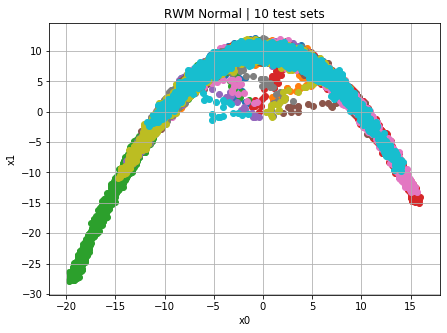

In [23]:
plt.figure(figsize=(7, 5));
plt.title('RWM Normal | 10 test sets');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');

### Laplace proposal

In [51]:
scale_grid = np.linspace(1e-7, 2, 100)

In [52]:
acceptance_ratios = []
for i, scale in enumerate(tqdm(scale_grid)):
    accepted, rejected = gen_samples_rwm(N=200, proposal='laplace', proposal_params={'loc': 0., 'scale': scale}, random_state=i)
    acceptance_ratios.append(len(accepted) / (len(accepted) + len(rejected)))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 152.37it/s]


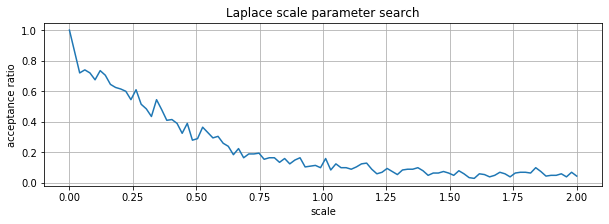

In [53]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(scale_grid, acceptance_ratios);
plt.xlabel('scale');
plt.ylabel('acceptance ratio');
plt.title('Laplace scale parameter search');

In [32]:
accepted_rwm_laplace, rejected_rwm_laplace = gen_samples_rwm(
    N=10000, proposal='laplace', proposal_params={'loc': 0., 'scale': 0.25}, random_state=1234
)
len(accepted_rwm_laplace), len(rejected_rwm_laplace)

(5681, 4319)

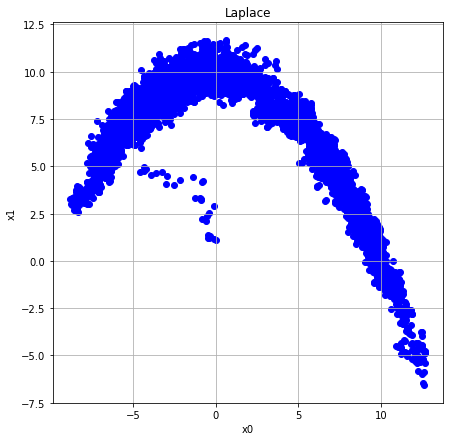

In [33]:
plt.figure(figsize=(7,7));

plt.title('Laplace')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted_rwm_laplace],
            y=[point[1] for point in accepted_rwm_laplace], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

**Empirical expectation for the second dimension**

In [34]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_rwm(N=10000, proposal='laplace', proposal_params={'loc': 0., 'scale': 0.25}, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.61it/s]


In [35]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Empirical expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Empirical expectation = 5.01721089216141


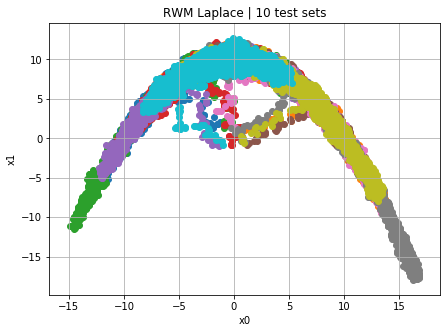

In [36]:
plt.figure(figsize=(7, 5));
plt.title('RWM Laplace | 10 test sets');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');